In [2]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from PIL import Image
import Metrics
import matplotlib.pyplot as plt

In [85]:
def encode_img_jpeg(img,x):
  img = tf.convert_to_tensor(img, dtype=tf.uint8)
  print(img)
  img = tf.io.encode_jpeg(img, format='rgb')
  img = tf.image.resize(img, [x, x])
  return img


In [4]:
(_, _), (test_images, _) = datasets.cifar10.load_data()
test_images = test_images[:10000]
# test_images = test_images.astype('float32') / 255.0
img_size = test_images.shape[1:]
print(test_images[0])

[[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 ...

 [[ 68 124 177]
  [ 42 100 148]
  [ 31  88 137]
  ...
  [ 38  97 146]
  [ 13  64 108]
  [ 40  85 127]]

 [[ 61 116 168]
  [ 49 102 148]
  [ 35  85 132]
  ...
  [ 26  82 130]
  [ 29  82 126]
  [ 20  64 107]]

 [[ 54 107 160]
  [ 56 105 149]
  [ 45  89 132]
  ...
  [ 24  77 124]
  [ 34  84 129]
  [ 21  67 110]]]


In [5]:
SNR = 20
x = 16
k = x**2*3
n = np.prod(img_size)
k_n = k/n

decode_img = []

In [91]:
img_pil = Image.fromarray(test_images[0].astype('uint8'))

img_pil.save('j.jpeg', format='JPEG', quality=0)

In [86]:
encode_img = encode_img_jpeg(test_images[0], x)

print(encode_img.numpy())

tf.Tensor(
[[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 ...

 [[ 68 124 177]
  [ 42 100 148]
  [ 31  88 137]
  ...
  [ 38  97 146]
  [ 13  64 108]
  [ 40  85 127]]

 [[ 61 116 168]
  [ 49 102 148]
  [ 35  85 132]
  ...
  [ 26  82 130]
  [ 29  82 126]
  [ 20  64 107]]

 [[ 54 107 160]
  [ 56 105 149]
  [ 45  89 132]
  ...
  [ 24  77 124]
  [ 34  84 129]
  [ 21  67 110]]], shape=(32, 32, 3), dtype=uint8)


ValueError: 'images' must have either 3 or 4 dimensions.

In [55]:
for test_image in test_images:
  encode_img.append(encode_img_jpeg(test_image, x))

ValueError: Tensor conversion requested dtype string for Tensor with dtype uint8: <tf.Tensor: shape=(32, 32, 3), dtype=uint8, numpy=
array([[[158, 112,  49],
        [159, 111,  47],
        [165, 116,  51],
        ...,
        [137,  95,  36],
        [126,  91,  36],
        [116,  85,  33]],

       [[152, 112,  51],
        [151, 110,  40],
        [159, 114,  45],
        ...,
        [136,  95,  31],
        [125,  91,  32],
        [119,  88,  34]],

       [[151, 110,  47],
        [151, 109,  33],
        [158, 111,  36],
        ...,
        [139,  98,  34],
        [130,  95,  34],
        [120,  89,  33]],

       ...,

       [[ 68, 124, 177],
        [ 42, 100, 148],
        [ 31,  88, 137],
        ...,
        [ 38,  97, 146],
        [ 13,  64, 108],
        [ 40,  85, 127]],

       [[ 61, 116, 168],
        [ 49, 102, 148],
        [ 35,  85, 132],
        ...,
        [ 26,  82, 130],
        [ 29,  82, 126],
        [ 20,  64, 107]],

       [[ 54, 107, 160],
        [ 56, 105, 149],
        [ 45,  89, 132],
        ...,
        [ 24,  77, 124],
        [ 34,  84, 129],
        [ 21,  67, 110]]], dtype=uint8)>

In [8]:
tf.print(Metrics.PSNR(train_images[0], train_images[1]))

10.0594463


In [3]:
(_, _), (test_images, _) = datasets.cifar10.load_data()
test_images = test_images[:10000]
img_size = test_images.shape[1:]

In [19]:
SNR = 20
P = 1
N = P/10**(SNR/10)
C = np.log2(1+SNR)
x = 20
k = x**2*3
n = np.prod(img_size)
k_n = k/n
R_max = k/n*C
R = R_max
# if R > 1:
#   Q = 0.5*R
# else:
#   Q=1-0.5/R
# Q = int(Q*100)
Q = R/8
Q = int(Q*100)
print(C)
print(R_max)
print(Q)
print(k_n)

4.392317422778761
1.7157489932729535
21
0.390625


In [15]:
def compress_image(image, quality):
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 100]
  result, encimg = cv2.imencode('.jpeg', image, encode_param)
  if not result:
    print('could not encode image!')
    return None
  decimg = cv2.imdecode(encimg, 1)
  decimg = cv2.imdecode(encimg, cv2.IMREAD_COLOR)
  decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
  return decimg

In [16]:
PSNR = []
for test_image in test_images:
  decode_img = compress_image(test_image, Q)
  decode_img = decode_img/255.0
  # print(np.mean(decode_img))
  P = np.mean(decode_img)
  N = P/10**(SNR/10)
  # noise = np.random.normal(0, np.sqrt(N), decode_img.shape)
  # print(noise)
  # decode_img = decode_img + noise
  # decode_img[decode_img > 1] = 1
  # decode_img[decode_img < 0] = 0
  test_image = test_image/255.0
  PSNR.append(Metrics.PSNR(decode_img, test_image))

In [17]:
PSNR_avg = sum(PSNR)/len(PSNR)
print(PSNR_avg)

tf.Tensor(39.33548, shape=(), dtype=float32)


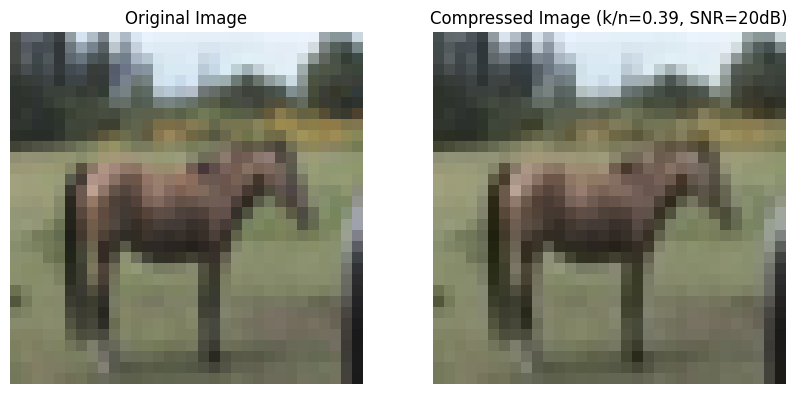

In [18]:
# 結果の表示
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_images[9999])
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(decode_img)
axes[1].set_title(f'Compressed Image (k/n={round(k_n, 2)}, SNR={SNR}dB)')
axes[1].axis('off')

plt.show()

In [77]:
decode_img = decode_img/255.0
test_image = test_images[0]/255.0

tf.print(Metrics.PSNR(decode_img, test_images[0]))

30.5848961


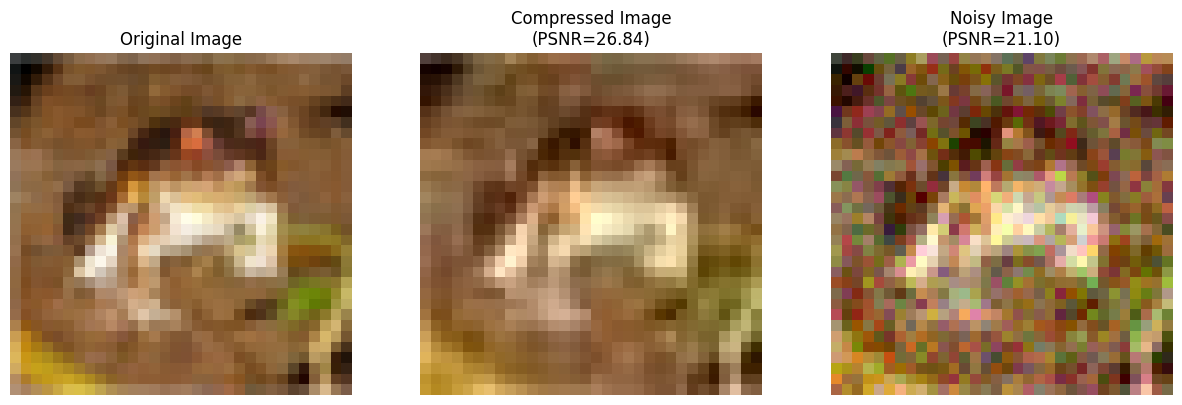

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from skimage.metrics import peak_signal_noise_ratio as psnr

# CIFAR-10データセットの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 最初の画像を取得
original_image = x_train[0]

# JPEGで圧縮
def compress_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # change color from RGB to BGR
    is_success, jpeg = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100)) # convert to jpeg
    if not is_success:
        print('could not encode image!')
        return None
    jpeg = cv2.imdecode(jpeg, cv2.IMREAD_COLOR)
    jpeg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
    return decimg

# AWGNノイズを追加
def add_awgn_noise(image, noise_std_dev):
    row, col, ch = image.shape
    mean = 0
    gauss = np.random.normal(mean, noise_std_dev, (row, col, ch))
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255)
    return noisy.astype(np.uint8)

# PSNRを計算
def calculate_psnr(original, compressed):
    return psnr(original, compressed, data_range=255)

# 圧縮レートを指定
quality = 50  # 圧縮レートを指定 (例: 50)
compressed_image = compress_image(original_image, quality)

# ノイズの標準偏差を指定してノイズを追加
noise_std_dev = 20
noisy_image = add_awgn_noise(compressed_image, noise_std_dev)

# PSNRの計算
psnr_compressed = calculate_psnr(original_image, compressed_image)
psnr_noisy = calculate_psnr(original_image, noisy_image)

# 結果の表示
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(compressed_image)
axes[1].set_title(f'Compressed Image\n(PSNR={psnr_compressed:.2f})')
axes[1].axis('off')

axes[2].imshow(noisy_image)
axes[2].set_title(f'Noisy Image\n(PSNR={psnr_noisy:.2f})')
axes[2].axis('off')

plt.show()


[255 216 255 ... 167 255 217]
[[[157 113  48]
  [156 112  47]
  [164 116  52]
  ...
  [137  95  35]
  [128  91  36]
  [117  84  30]]

 [[155 112  44]
  [153 108  41]
  [161 113  47]
  ...
  [136  94  34]
  [126  90  32]
  [120  88  31]]

 [[154 109  41]
  [154 107  39]
  [160 110  41]
  ...
  [138  98  36]
  [131  95  35]
  [123  88  30]]

 ...

 [[ 70 123 175]
  [ 45  98 150]
  [ 34  87 139]
  ...
  [ 42  95 145]
  [ 15  62 108]
  [ 40  85 127]]

 [[ 62 114 164]
  [ 49 101 149]
  [ 34  84 133]
  ...
  [ 29  81 129]
  [ 32  80 126]
  [ 18  65 109]]

 [[ 55 107 155]
  [ 54 104 153]
  [ 42  90 138]
  ...
  [ 25  77 124]
  [ 35  83 129]
  [ 20  67 111]]]


NameError: name 'original_image' is not defined

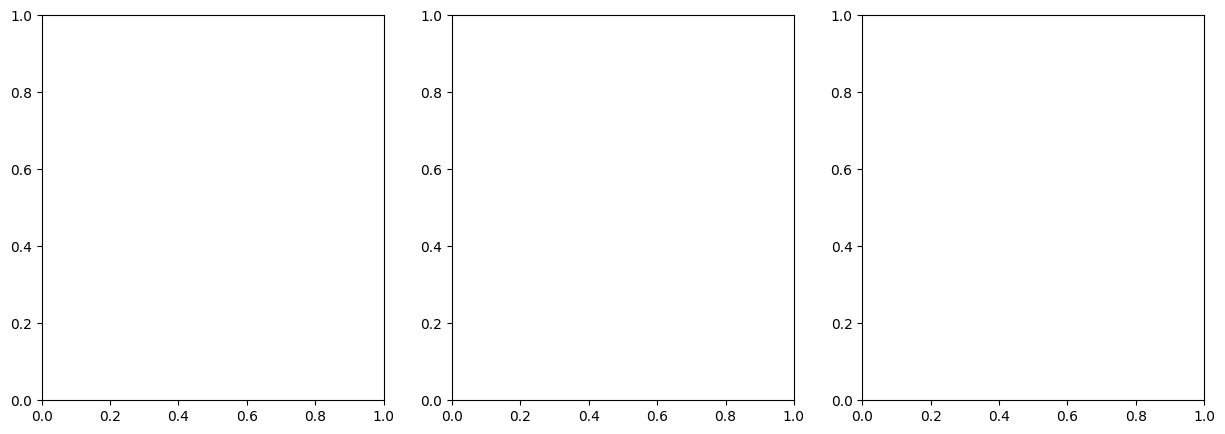

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from skimage.metrics import peak_signal_noise_ratio as psnr

# CIFAR-10データセットの読み込み
(_, _), (org_img, _) = cifar10.load_data()

# convert image to jpeg
def img2jpeg(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # change color from RGB to BGR
    is_success, jpeg = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100)) # convert to jpeg
    if not is_success:
        print('could not encode image!')
        return None
    print(jpeg)
    jpeg = cv2.imdecode(jpeg, cv2.IMREAD_COLOR) # decode
    jpeg = cv2.cvtColor(jpeg, cv2.COLOR_BGR2RGB)  # change clolor from BGR to RGB
    return jpeg


# PSNRを計算
def calculate_psnr(original, compressed):
    return psnr(original, compressed, data_range=255)

jpeg = img2jpeg(org_img[0])

print(jpeg)




# PSNRの計算
# psnr_compressed = calculate_psnr(original_image, compressed_image)
# psnr_noisy = calculate_psnr(original_image, noisy_image)

# 結果の表示
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(compressed_image)
axes[1].set_title(f'Compressed Image\n(PSNR={psnr_compressed:.2f})')
axes[1].axis('off')

axes[2].imshow(noisy_image)
axes[2].set_title(f'Noisy Image\n(PSNR={psnr_noisy:.2f})')
axes[2].axis('off')

plt.show()


In [13]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os

# CIFAR-10データセットをロード
(_, _), (org_img, _) = tf.keras.datasets.cifar10.load_data()

org_img = org_img[:100]

# トレーニングデータの画像を保存
for i in range(org_img.shape[0]):
  img = Image.fromarray(org_img[i])
  img.save(f"./images/org_img_{i}.png")

print(img)
print("画像の保存が完了しました。")


<PIL.Image.Image image mode=RGB size=32x32 at 0x19BCB068450>
画像の保存が完了しました。


TypeError: 'Image' object is not subscriptable

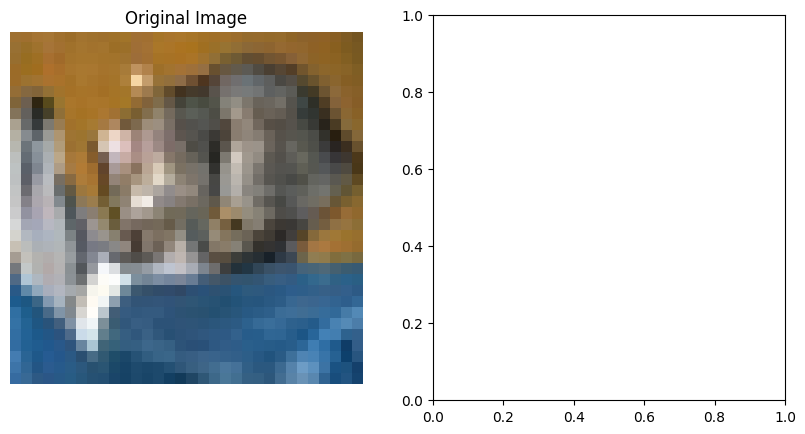

In [14]:
# 結果の表示
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(org_img[0])
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img[0])
axes[1].set_title(f'JPEG')
axes[1].axis('off')

plt.show()

In [37]:
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

In [67]:
(_, _), (org_img, _) = datasets.cifar10.load_data()
opg_img = org_img[:10000]

n = 32*32*3

DIR = 'images'
os.makedirs(DIR, exist_ok=True)
img = Image.fromarray(org_img[0])
img.save(f'{DIR}/org_img.bmp')
for i in range(101):
  img.save(f'{DIR}/quality_{i}.jpeg', format='JPEG', quality=i)


In [74]:
print(len(org_img[0].tobytes()))

3072


In [64]:
file_size = []
for i in range(101):
  file_size.append(os.path.getsize(f'{DIR}/quality_{i}.jpeg'))

R_max = [file_size/n*8 for file_size in file_size]

In [80]:
jpeg_img = np.array(Image.open(f'{DIR}/quality_35.jpeg'))
bmp_img = np.array(Image.open(f'{DIR}/org_img.bmp'))
print(psnr(org_img[0], jpeg_img, data_range=255))
print(psnr(org_img[0], bmp_img, data_range=255))
print(file_size[35])

25.41356706265465
inf
777


c:\Users\naoki\PythonVenv\StudyVenv\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


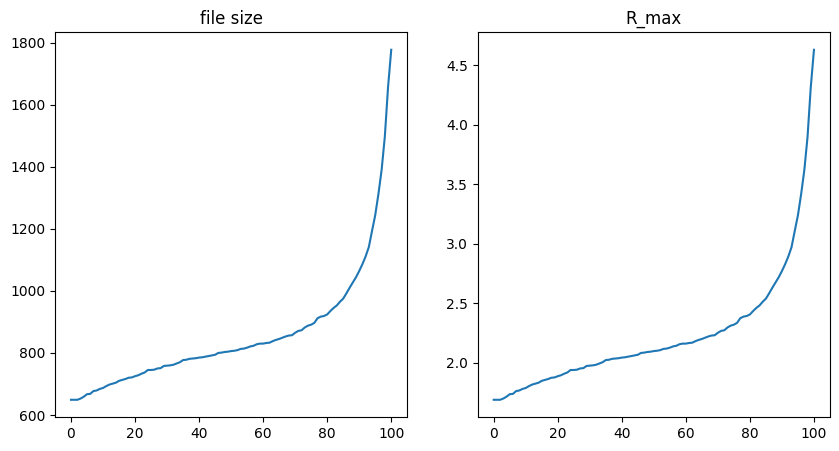

In [81]:
# 結果の表示
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(file_size)
axes[0].set_title('file size')

axes[1].plot(R_max)
axes[1].set_title('R_max')

plt.show()

In [32]:
import cv2, statistics
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm

(_, _), (org_img, _) = tf.keras.datasets.cifar10.load_data()
org_img = org_img[:1]


def get_jpeg_size(img, quality):
  # jpeg_bytes = cv2.imwrite(f'{quality}.jp2', img, [cv2.IMWRITE_JPEG2000_COMPRESSION_X1000, quality])
  jpeg_bytes = cv2.imencode('.jp2', img, [cv2.IMWRITE_JPEG2000_COMPRESSION_X1000, quality])[1].tobytes()

  data_size = len(jpeg_bytes)

  return data_size



data_size = []
data_size_avg = []
quality = np.arange(0, 1001, 1)
for q in tqdm.tqdm(quality):
  for img in org_img:
    data_size.append(get_jpeg_size(img, q))
  avg = statistics.mean(data_size)
  data_size_avg.append(avg)
    



100%|██████████| 1001/1001 [00:05<00:00, 189.12it/s]


[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255.07407407407408, 255.14634146341464, 255.21686746987953, 255.38095238095238, 255.6, 255.84883720930233, 256.1264367816092, 256.4318181818182, 256.7303370786517, 257.1, 257.4835164835165, 257.9021739130435, 258.3333333333333, 258.75531914893617, 259.22105263157897, 259.7083333333333, 260.21649484536084, 260.765306122449, 261.3030303030303, 261.88, 262.44554455445547, 263.0686274509804, 263.70873786407765, 264.3557692307692, 265.03809523809525, 265.72641509433964, 266.4392523364486, 267.1388888888889, 267.86238532110093, 268.57272727272726, 269.34234234234236, 270.11607142857144, 270.9026548

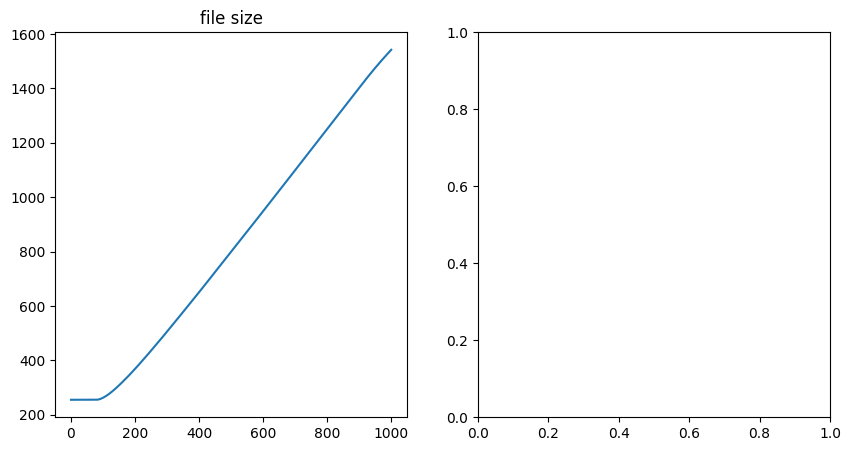

In [33]:
# 結果の表示
print(data_size_avg)
print(quality)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(quality, data_size_avg)
axes[0].set_title('file size')


plt.show()

In [27]:
import cv2, statistics
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

(_, _), (org_img, _) = tf.keras.datasets.cifar10.load_data()
org_img = org_img[:100]

n = org_img[0].size

SNR = 20
k_n = 0.4
C = np.log2(1+SNR)
R_max = k_n*C
s = int(np.sqrt(n*R_max/(8*3)))

def jpeg_resize(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  # _, jpeg = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
  # jpeg_comp = cv2.imdecode(jpeg, cv2.IMREAD_COLOR)
  jpeg_resize =  cv2.resize(img, (s, s))
  jpeg_comp = cv2.resize(jpeg_resize, (32, 32))
  # jpeg_comp = cv2.imdecode(jpeg_comp, cv2.IMREAD_COLOR) # decode
  jpeg_comp = cv2.cvtColor(jpeg_comp, cv2.COLOR_BGR2RGB)
  return jpeg_comp

psnr(org_img[0], jpeg_resize(org_img[0]), data_range=255)




22.7128748665563

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # change color from RGB to BGR
_, jpeg = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100)) # convert to jpeg
jpeg = cv2.imdecode(jpeg, cv2.IMREAD_COLOR) # decode
jpeg = cv2.cvtColor(jpeg, cv2.COLOR_BGR2RGB)  # change clolor from BGR to RGB

In [10]:
import cv2, statistics, tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

(_, _), (org_img, _) = tf.keras.datasets.cifar10.load_data()
org_img = org_img[:10000]

n = org_img[0].size

SNR = 20
k_n = 0.5
C = np.log2(1+SNR)
R_max = k_n*C
data_size_max = n*R_max/8


def get_jpeg_size(img, quality):
  jpeg_bytes = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])[1].tobytes()

  data_size = len(jpeg_bytes)
  return data_size

def jpeg_compression(img, quality):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # change color from RGB to BGR
  _, jpeg = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, quality)) # convert to jpeg
  jpeg = cv2.imdecode(jpeg, cv2.IMREAD_COLOR) # decode
  jpeg = cv2.cvtColor(jpeg, cv2.COLOR_BGR2RGB)  # change clolor from BGR to RGB
  return jpeg

data_size_list = []
data_size_avg = []
quality = np.arange(100, -1, -1)
quality_list = []
jpeg_list = []
psnr = []


for img in tqdm.tqdm(org_img):
  for q in quality:
    data_size = get_jpeg_size(img, q)
    if data_size < data_size_max:
      data_size_list.append(data_size)
      jpeg = jpeg_compression(img, q)
      jpeg_list.append(jpeg)
      psnr.append(peak_signal_noise_ratio(img, jpeg, data_range=255))
      break


psnr_avg = statistics.mean(psnr)

print(f'k/n={k_n}, data_size={data_size_max}Bytes, PSNR={psnr_avg}')  
  



    



100%|██████████| 10000/10000 [00:03<00:00, 2873.26it/s]

k/n=0.5, data_size=1686.6498903470442Bytes, PSNR=38.816131418921216


In [1]:
import cv2, statistics, tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio
from PIL import Image

In [6]:


(_, _), (org_img, _) = tf.keras.datasets.cifar10.load_data()
org_img = org_img[:10]

n = org_img[0].size

SNR = 20
k_n = 0.4
C = np.log2(1+SNR)
R_max = k_n*C
data_size_max = n*R_max/4


def get_jpeg_size(img, quality):
  jpeg_bytes = cv2.imencode('.jp2', img, [int(cv2.IMWRITE_JPEG2000_COMPRESSION_X1000), quality])[1].tobytes()

  data_size = len(jpeg_bytes)
  return data_size

def jpeg_compression(img, quality):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # change color from RGB to BGR
  _, jpeg = cv2.imencode('.jp2', img, (cv2.IMWRITE_JPEG2000_COMPRESSION_X1000, quality)) # convert to jpeg
  jpeg = cv2.imdecode(jpeg, cv2.IMREAD_COLOR) # decode
  jpeg = cv2.cvtColor(jpeg, cv2.COLOR_BGR2RGB)  # change clolor from BGR to RGB
  return jpeg

data_size_list = []
data_size_avg = []
quality = np.arange(1000, -1, -1)
quality_list = []
jpeg_list = []
psnr = []


for img in tqdm.tqdm(org_img):
  for q in quality:
    data_size = get_jpeg_size(img, q)
    if data_size < data_size_max:
      data_size_list.append(data_size)
      jpeg = jpeg_compression(img, q)
      jpeg_list.append(jpeg)
      psnr.append(peak_signal_noise_ratio(img, jpeg, data_range=255))
      break


psnr_avg = statistics.mean(psnr)

print(f'k/n={k_n}, data_size={data_size_max}Bytes, PSNR={psnr_avg}')  
  



    



100%|██████████| 10/10 [00:25<00:00,  2.57s/it]

k/n=0.4, data_size=1349.3199122776355Bytes, PSNR=37.261605800032754


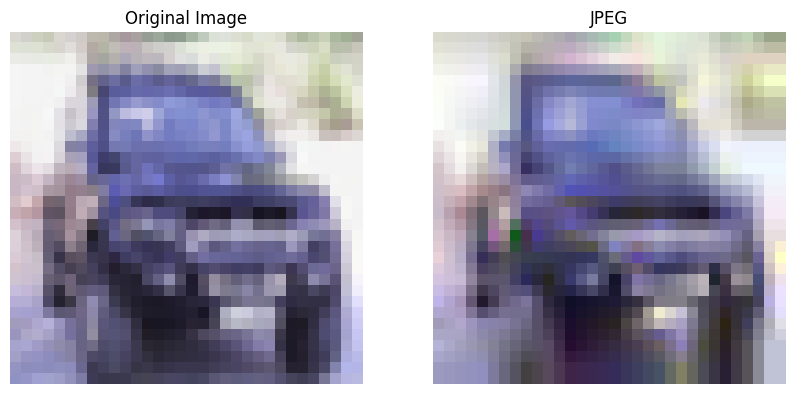

In [5]:
# 結果の表示
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(org_img[9])
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(jpeg)
axes[1].set_title(f'JPEG')
axes[1].axis('off')

plt.show()

In [15]:
import cv2, statistics, tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

(_, _), (org_img, _) = tf.keras.datasets.cifar10.load_data()
org_img = org_img[:10000]

n = org_img[0].size

SNR = 20
k_n = 0.42
C = np.log2(1+SNR)
R_max = k_n*C
data_size_max = n*R_max/8


def get_jpeg_size(img, quality):
  jpeg_bytes = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])[1].tobytes()

  data_size = len(jpeg_bytes)
  return data_size

def jpeg_compression(img, quality):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # change color from RGB to BGR
  _, jpeg = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, quality)) # convert to jpeg
  jpeg = cv2.imdecode(jpeg, cv2.IMREAD_UNCHANGED) # decode
  jpeg = cv2.cvtColor(jpeg, cv2.COLOR_BGR2RGB)  # change clolor from BGR to RGB
  return jpeg

def img_destruction(img):
  img_shape = img.shape
  dest = np.zeros(img_shape)
  mean = np.zeros(img_shape[2])
  for i in range(img_shape[2]):
    mean = statistics.mean(img[:,:,i])
    dest[:,:,i] = np.full(img_shape[:2], mean)
  return dest

data_size_list = []
data_size_avg = []
quality = np.arange(100, -1, -1)
quality_list = []
jpeg_list = []
psnr = []


for img in tqdm.tqdm(org_img):
  for q in quality:
    data_size = get_jpeg_size(img, q)
    if data_size < data_size_max:
      data_size_list.append(data_size)
      jpeg = jpeg_compression(img, q)
      break
    elif q == quality[-1]:
      jpeg = img_destruction(img)
  jpeg_list.append(jpeg)
  psnr.append(peak_signal_noise_ratio(img, jpeg, data_range=255))


psnr_avg = statistics.mean(psnr)

print(f'k/n={k_n}, data_size={data_size_max}Bytes, PSNR={psnr_avg}')  

100%|██████████| 10000/10000 [00:08<00:00, 1210.46it/s]

k/n=0.42, data_size=1100Bytes, PSNR=33.53147805066861


In [32]:
import cv2, tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

psnr_avg_list = []

(_, _), (org_img, _) = tf.keras.datasets.cifar10.load_data()
org_img = org_img[:10000]

n = org_img[0].size

SNR = 20
k_n_list = [0.05, 0.1, 0.2, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
# k_n_list = [0.05, 0.3, 0.48, 0.5]
C = np.log2(1+SNR)

quality = np.arange(100, -1, -1)

def jpeg_compression(img, quality):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # change color from RGB to BGR
  _, jpeg = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, quality)) # convert to jpeg
  jpeg = cv2.imdecode(jpeg, cv2.IMREAD_UNCHANGED) # decode
  jpeg = cv2.cvtColor(jpeg, cv2.COLOR_BGR2RGB)  # change clolor from BGR to RGB
  return jpeg

def img_destruction(img):
  img_shape = img.shape
  dest = np.zeros(img_shape)
  mean = np.zeros(img_shape[2])
  for i in range(img_shape[2]):
    mean = np.mean(img[:,:,i])
    dest[:,:,i] = np.full(img_shape[:2], mean)
  return dest

for k_n in k_n_list:
  R_max = k_n*C
  data_size_max = n*R_max/4
  def get_jpeg_size(img, quality):
    jpeg_bytes = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])[1].tobytes()

    data_size = len(jpeg_bytes)
    return data_size

  

  data_size_list = []
  data_size_avg = []

  quality_list = []
  jpeg_list = []
  psnr = []


  for img in tqdm.tqdm(org_img):
    for q in quality:
      data_size = get_jpeg_size(img, q)
      if data_size < data_size_max:
        data_size_list.append(data_size)
        jpeg = jpeg_compression(img, q)
        break
      elif q == quality[-1]:
        jpeg = img_destruction(img)
    jpeg_list.append(jpeg)
    psnr.append(peak_signal_noise_ratio(img, jpeg, data_range=255))


  psnr_avg = np.mean(psnr)
  psnr_avg_list.append(psnr_avg)

  print(f'k/n={k_n}, data_size={data_size_max}Bytes, PSNR={psnr_avg}')  


100%|██████████| 10000/10000 [00:48<00:00, 207.83it/s]


k/n=0.05, data_size=66.42108707783612Bytes, PSNR=14.3207772209529


100%|██████████| 10000/10000 [00:48<00:00, 207.58it/s]


k/n=0.3, data_size=398.52652246701666Bytes, PSNR=14.3207772209529


100%|██████████| 10000/10000 [00:46<00:00, 216.72it/s]


k/n=0.48, data_size=637.6424359472267Bytes, PSNR=14.3207772209529


100%|██████████| 10000/10000 [00:45<00:00, 220.59it/s]

k/n=0.5, data_size=664.2108707783611Bytes, PSNR=19.508709826209703


In [34]:
import cv2, tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

psnr_avg_list = []

(_, _), (org_img, _) = tf.keras.datasets.cifar10.load_data()
org_img = org_img[:100]

n = org_img[0].size
# n = 3200

SNR = 20
# k_n_list = [0.05, 0.1, 0.15,  0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
k_n_list = [0.05, 0.08, 0.16,  0.2, 0.25, 0.3, 0.33, 0.35, 0.4, 0.42, 0.45, 0.48, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
# k_n_list = [0.05, 0.2, 0.3, 0.4, 0.48]
C = np.log2(1+SNR)

quality = np.arange(0, 101, 1)

def jpeg_compression(img, quality):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # change color from RGB to BGR
  _, jpeg = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, quality)) # convert to jpeg
  jpeg = cv2.imdecode(jpeg, cv2.IMREAD_UNCHANGED) # decode
  jpeg = cv2.cvtColor(jpeg, cv2.COLOR_BGR2RGB)  # change clolor from BGR to RGB
  return jpeg

def img_destruction(img):
  img_shape = img.shape
  dest = np.zeros(img_shape)
  mean = np.zeros(img_shape[2])
  for i in range(img_shape[2]):
    mean = np.mean(img[:,:,i])
    dest[:,:,i] = np.full(img_shape[:2], mean)
  return dest

def get_jpeg_size(img, quality):
    jpeg_bytes = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])[1].tobytes()

    data_size = len(jpeg_bytes)
    return data_size

for k_n in k_n_list:
  R_max = k_n*C
  data_size_max = n*R_max/8*1.5
  

  

  data_size_list = []
  data_size_avg = []

  quality_list = []
  jpeg_list = []
  psnr = []


  for img in tqdm.tqdm(org_img):
    data_size_old = 0
    for q in quality:
      data_size_new = get_jpeg_size(img, q)      
      if data_size_new > data_size_max:
        if q == 0:
          jpeg = img_destruction(img)
        else:
          data_size_list.append(data_size_old)
          jpeg = jpeg_compression(img, q-1)
        break
      elif q == quality[-1]:
        jpeg = jpeg_compression(img, q)
      data_size_old = data_size_new
    jpeg_list.append(jpeg)
    psnr.append(peak_signal_noise_ratio(img, jpeg, data_range=255))


  psnr_avg = np.mean(psnr)
  psnr_avg_list.append(psnr_avg)

  print(f'k/n={k_n}, data_size={data_size_max}Bytes, PSNR={psnr_avg}')  


100%|██████████| 100/100 [00:00<00:00, 3013.45it/s]


k/n=0.05, data_size=126.49874177602833Bytes, PSNR=14.238841444532087


100%|██████████| 100/100 [00:00<00:00, 6460.03it/s]


k/n=0.08, data_size=202.39798684164532Bytes, PSNR=14.238841444532087


100%|██████████| 100/100 [00:00<00:00, 4400.23it/s]


k/n=0.16, data_size=404.79597368329064Bytes, PSNR=14.238841444532087


100%|██████████| 100/100 [00:00<00:00, 3590.18it/s]


k/n=0.2, data_size=505.9949671041133Bytes, PSNR=14.238841444532087


100%|██████████| 100/100 [00:00<00:00, 6287.18it/s]


k/n=0.25, data_size=632.4937088801416Bytes, PSNR=14.238841444532087


100%|██████████| 100/100 [00:00<00:00, 584.74it/s]


k/n=0.3, data_size=758.9924506561699Bytes, PSNR=26.241631592058308


100%|██████████| 100/100 [00:00<00:00, 309.32it/s]


k/n=0.33, data_size=834.8916957217867Bytes, PSNR=28.520701148192543


100%|██████████| 100/100 [00:00<00:00, 261.27it/s]


k/n=0.35, data_size=885.4911924321982Bytes, PSNR=29.642306846259313


100%|██████████| 100/100 [00:00<00:00, 164.75it/s]


k/n=0.4, data_size=1011.9899342082266Bytes, PSNR=31.96336813274383


100%|██████████| 100/100 [00:00<00:00, 223.71it/s]


k/n=0.42, data_size=1062.5894309186378Bytes, PSNR=32.79371592904044


100%|██████████| 100/100 [00:00<00:00, 217.36it/s]


k/n=0.45, data_size=1138.4886759842548Bytes, PSNR=33.896478533562245


100%|██████████| 100/100 [00:00<00:00, 212.49it/s]


k/n=0.48, data_size=1214.3879210498717Bytes, PSNR=34.889114196510555


100%|██████████| 100/100 [00:00<00:00, 193.21it/s]


k/n=0.5, data_size=1264.9874177602833Bytes, PSNR=35.49893152274142


100%|██████████| 100/100 [00:00<00:00, 194.68it/s]


k/n=0.55, data_size=1391.4861595363116Bytes, PSNR=36.78176641842268


100%|██████████| 100/100 [00:00<00:00, 183.28it/s]


k/n=0.6, data_size=1517.9849013123398Bytes, PSNR=37.83349343579604


100%|██████████| 100/100 [00:00<00:00, 142.71it/s]


k/n=0.65, data_size=1644.4836430883684Bytes, PSNR=38.51044656867225


100%|██████████| 100/100 [00:00<00:00, 186.62it/s]


k/n=0.7, data_size=1770.9823848643964Bytes, PSNR=38.967519253456786


100%|██████████| 100/100 [00:00<00:00, 178.01it/s]


k/n=0.75, data_size=1897.481126640425Bytes, PSNR=39.16332604526318


100%|██████████| 100/100 [00:00<00:00, 176.90it/s]

k/n=0.8, data_size=2023.9798684164532Bytes, PSNR=39.209915793012534


In [53]:
import cv2, tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

psnr_avg_list = []

(_, _), (org_img, _) = tf.keras.datasets.cifar10.load_data()
org_img = org_img[:100]

n = org_img[0].size

SNR = 10
# k_n_list_c = [0.04, 0.08, 0.16, 0.25, 0.33, 0.42, 0.48]
# k_n_list = [0.05, 0.08, 0.16,  0.2, 0.25, 0.3, 0.33, 0.35, 0.4, 0.42, 0.45, 0.48, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
k_n_list = [0.04, 0.08, 0.16, 0.25, 0.33, 0.42, 0.48]
# k_n_list = [0.05, 0.2, 0.3, 0.4, 0.48]
C = np.log2(1+SNR)

quality = np.arange(0, 1001, 1)

def jpeg_compression(img, quality):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # change color from RGB to BGR
  _, jpeg = cv2.imencode('.jp2', img, (cv2.IMWRITE_JPEG2000_COMPRESSION_X1000, quality)) # convert to jpeg
  jpeg = cv2.imdecode(jpeg, cv2.IMREAD_UNCHANGED) # decode
  jpeg = cv2.cvtColor(jpeg, cv2.COLOR_BGR2RGB)  # change clolor from BGR to RGB
  return jpeg

def img_destruction(img):
  img_shape = img.shape
  dest = np.zeros(img_shape)
  mean = np.zeros(img_shape[2])
  for i in range(img_shape[2]):
    mean = np.mean(img[:,:,i])
    dest[:,:,i] = np.full(img_shape[:2], mean)
  return dest

def get_jpeg_size(img, quality):
    jpeg_bytes = cv2.imencode('.jp2', img, [int(cv2.IMWRITE_JPEG2000_COMPRESSION_X1000), quality])[1].tobytes()

    data_size = len(jpeg_bytes)
    return data_size

for k_n in k_n_list:
  R_max = k_n*C
  data_size_max = n*R_max/8*2.5
  

  

  data_size_list = []
  data_size_avg = []

  quality_list = []
  jpeg_list = []
  psnr = []


  for img in tqdm.tqdm(org_img):
    data_size_old = 0
    for q in quality:
      data_size_new = get_jpeg_size(img, q)      
      if data_size_new > data_size_max:
        if q == 0:
          jpeg = img_destruction(img)
        else:
          data_size_list.append(data_size_old)
          jpeg = jpeg_compression(img, q-1)
        break
      data_size_old = data_size_new
    jpeg_list.append(jpeg)
    psnr.append(peak_signal_noise_ratio(img, jpeg, data_range=255))


  psnr_avg = np.mean(psnr)
  psnr_avg_list.append(psnr_avg)

  print(f'k/n={k_n}, data_size={data_size_max}Bytes, PSNR={psnr_avg}')  


100%|██████████| 100/100 [00:01<00:00, 76.59it/s]


k/n=0.04, data_size=168.66498903470443Bytes, PSNR=14.238841444532087


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


k/n=0.08, data_size=337.32997806940887Bytes, PSNR=18.6663407037119


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


k/n=0.16, data_size=674.6599561388177Bytes, PSNR=27.362074728495767


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


k/n=0.25, data_size=1054.1561814669026Bytes, PSNR=33.8381835806786


100%|██████████| 100/100 [03:50<00:00,  2.30s/it]


k/n=0.33, data_size=1391.4861595363113Bytes, PSNR=38.70774989100741


100%|██████████| 100/100 [05:23<00:00,  3.23s/it]


k/n=0.42, data_size=1770.9823848643964Bytes, PSNR=43.12023195474231


100%|██████████| 100/100 [06:21<00:00,  3.82s/it]

k/n=0.48, data_size=2023.9798684164525Bytes, PSNR=45.23423492829241


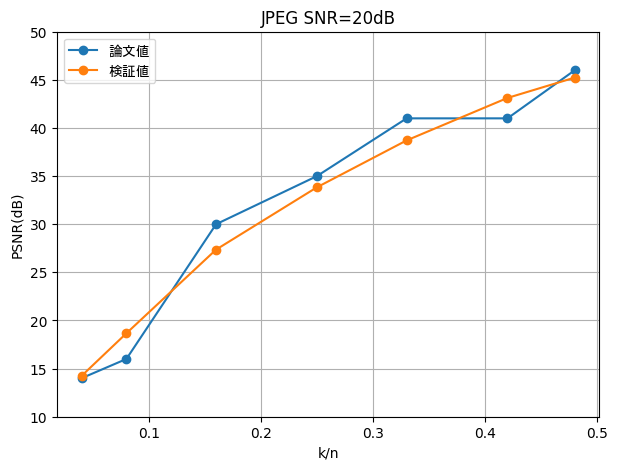

In [54]:
k_n_list_c = [0.04, 0.08, 0.16, 0.25, 0.33, 0.42, 0.48]
# psnr_avg_list_c = [14, 14, 14, 14, 29, 33, 35]
# psnr_avg_list_c = [14, 14, 14, 14, 14, 14, 14]
# psnr_avg_list_c = [14, 14, 17, 26, 30, 33, 35]
psnr_avg_list_c = [14, 16, 30, 35, 41, 41, 46]

fig = plt.figure(figsize=(7,5))
axes = fig.add_subplot(1,1,1, title='JPEG SNR=20dB', xlabel='k/n', ylabel='PSNR(dB)')

axes.plot(k_n_list_c, psnr_avg_list_c, '-', marker='o')
axes.plot(k_n_list, psnr_avg_list, '-', marker='o')

axes.legend(['論文値', '検証値'], prop={"family":"MS Gothic"})
axes.set_ylim([10,50])

plt.grid()


plt.show()

In [5]:
import numpy as np

SNR = 20
P = 1
scale = np.sqrt(P/10**(SNR/10))
n = 32*32*3
sigma_2 = 0
for i in range(n):
  sigma_2 += (np.random.normal(loc=0, scale=scale))**2

sigma_2 = sigma_2/n
print(scale)
print(sigma_2)

0.1
0.009493133905093801


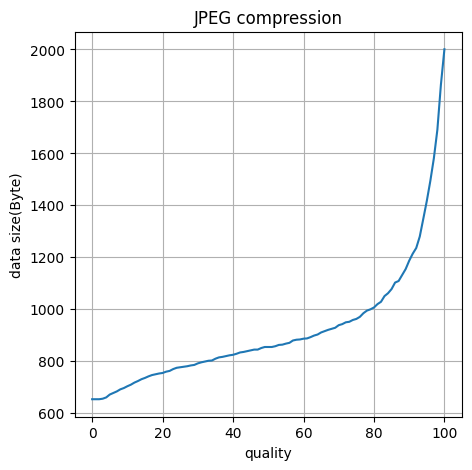

In [32]:
import cv2, tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

psnr_avg_list = []

(_, _), (org_img, _) = tf.keras.datasets.cifar10.load_data()
org_img = org_img[0]

n = org_img[0].size

def get_jpeg_size(img, quality):
  jpeg_bytes = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])[1].tobytes()

  data_size = len(jpeg_bytes)
  return data_size

quality = np.arange(0, 101, 1)
data_size = []
for q in quality:
  data_size.append(get_jpeg_size(org_img, q))

fig = plt.figure(figsize=(5,5))
axes = fig.add_subplot(1,1,1, title='JPEG compression', xlabel='quality', ylabel='data size(Byte)')

axes.plot(quality, data_size)


plt.grid()


plt.show()